# Butterfly Ballot Analysis

The 2000 US Presidential election was the closest election in all of American history. On Nov 7th, 2000, the nation watched entranced as the election came down to the last county, Palm Beach County (PBC) in the state of Florida. Tuesday night, Geroge W. Bush was announced the victory by a margin of 537 out of nearly 6M votes - a 0.009% margin!   The true chaos began the next morning, when voters from PBC filed lawsuits claiming that the confusing nature their new ballot format, the butterfly ballot, had led them to either spoiling their ballot or voting for the wrong candidate. Amost instantly, statisticians across the nation dived into the data to see if these allegations could be supported and determine the scale of the problem.

## Brief Background on the Butterfly Ballot

Below is the notorious butterfly ballot used in PBC for the 2000 Presidential election. 

![](fig/butterfly.jpg)

Many voters argued that the confusing nature of the alternating slots misled them to punching the second slot and voting for Reform Party candidate Buchanan instead of Democractic Party condidate Al Gore. Some voters even stated that pollsters and volunteers themselves did not know how to use that ballot. Pollsters told some voters that the right way to vote for Al Gore was to punch both the 2nd and 3rd slots, which misled many people into spoiling their ballots. Absentee voters on the other hand did not use the butterfly ballot at all. 

To learn more about the history of the controversy and prior analysis done on this subject, feel free to read the 2 papers under the `papers/` directory and/or for a quick summary and reflection of those paper, read `reading.md`

We'll be examining the vote count data from couties in Florida and trying to answer the following 3 questions:

* Was there a miscast of votes in PBC?
* Can this anomaly be attributed to the butterfly ballot?
* Did the miscast cost Al Gore the 2000 election?

Having understood the context and established our objective, let's begin our analysis by examing our dataset.

## Data Exploration 

We are using the **county_FL** dataset which can be found in the `data/` directory. In it, we have a list of all the counties in Florida and the following 6 variables:

* "totalVotes": count of total votes successfully cast in that county
* "buchananVotes": count of election day votes cast for Buchanan
* "goreVotes": count of election day votes cast for Gore
* "bushVotes": count of election day votes cast for Bush
* "absVotes": count of total absentee votes cast for that county
* "absBuchanan": count of absentee votes cast in that Buchanan

Let's load in our dataset. 

In [2]:
# Loading the libraries we will use and setting global options

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Suppressing warnings
import warnings
warnings.simplefilter(action = "ignore")

In [94]:
# Save our dataset to a df
fl_counties = pd.read_csv("data/county_fl.csv")

#Get rid of extra spaces after county names
fl_counties['county'] = fl_counties['county'].map(lambda x: x.strip())

fl_counties.head()

,county,totalVotes,buchananVotes,goreVotes,bushVotes,absVotes,absBuchanan
0,Alachua,85729,263,47365,34124,10694,40
1,Baker,8154,73,2392,5610,1111,4
2,Bay,58805,248,18850,38637,12587,37
3,Bradford,8673,65,3075,5414,1126,4
4,Brevard,218395,570,97318,115185,31811,83


Let's take a look at quick 5 point summaries of our variables.

In [14]:
fl_counties.describe()

,totalVotes,buchananVotes,goreVotes,bushVotes,absVotes,absBuchanan
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,88964.477612,260.880597,43453.985075,43450.970149,10605.626866,27.537313
std,131937.301230,450.498092,75070.435056,57182.620266,12866.618302,30.033985
min,2410.000000,9.000000,789.000000,1317.000000,211.000000,0.000000
25%,8082.000000,46.500000,3058.000000,4757.000000,1118.500000,5.500000
50%,35149.000000,120.000000,14167.000000,20206.000000,5581.000000,16.000000
75%,103040.000000,285.500000,46015.000000,56546.500000,13843.000000,40.000000
max,625449.000000,3411.000000,387703.000000,289533.000000,48525.000000,129.000000


Seems like we have all 67 Florida counties represented here. The average county total votes is around 89000 with half of the counties having total votes cast under 35,149. This implies a right tail skewed distribution where there are many counties with small total votes and then a few votes with huge totals votes. This disparity between county sizes may cause issues of heteroskedasticity when we do our regression later.

Another thing to note is that the sample size for absentee votes is much smaller than the sample for election day or in person voters - especially when subsetting by Buchanan votes. The average # of votes cast for Buchanan is 27 in the absentee pool. We should keep that in mind if we use the absentee Buchanan vote proportion to model how many eleciton day voter meant to vote for Buchanan. 

Let's take a look the proportion and raw votes of Buchanan voters by county for both absentee and election day voters. 

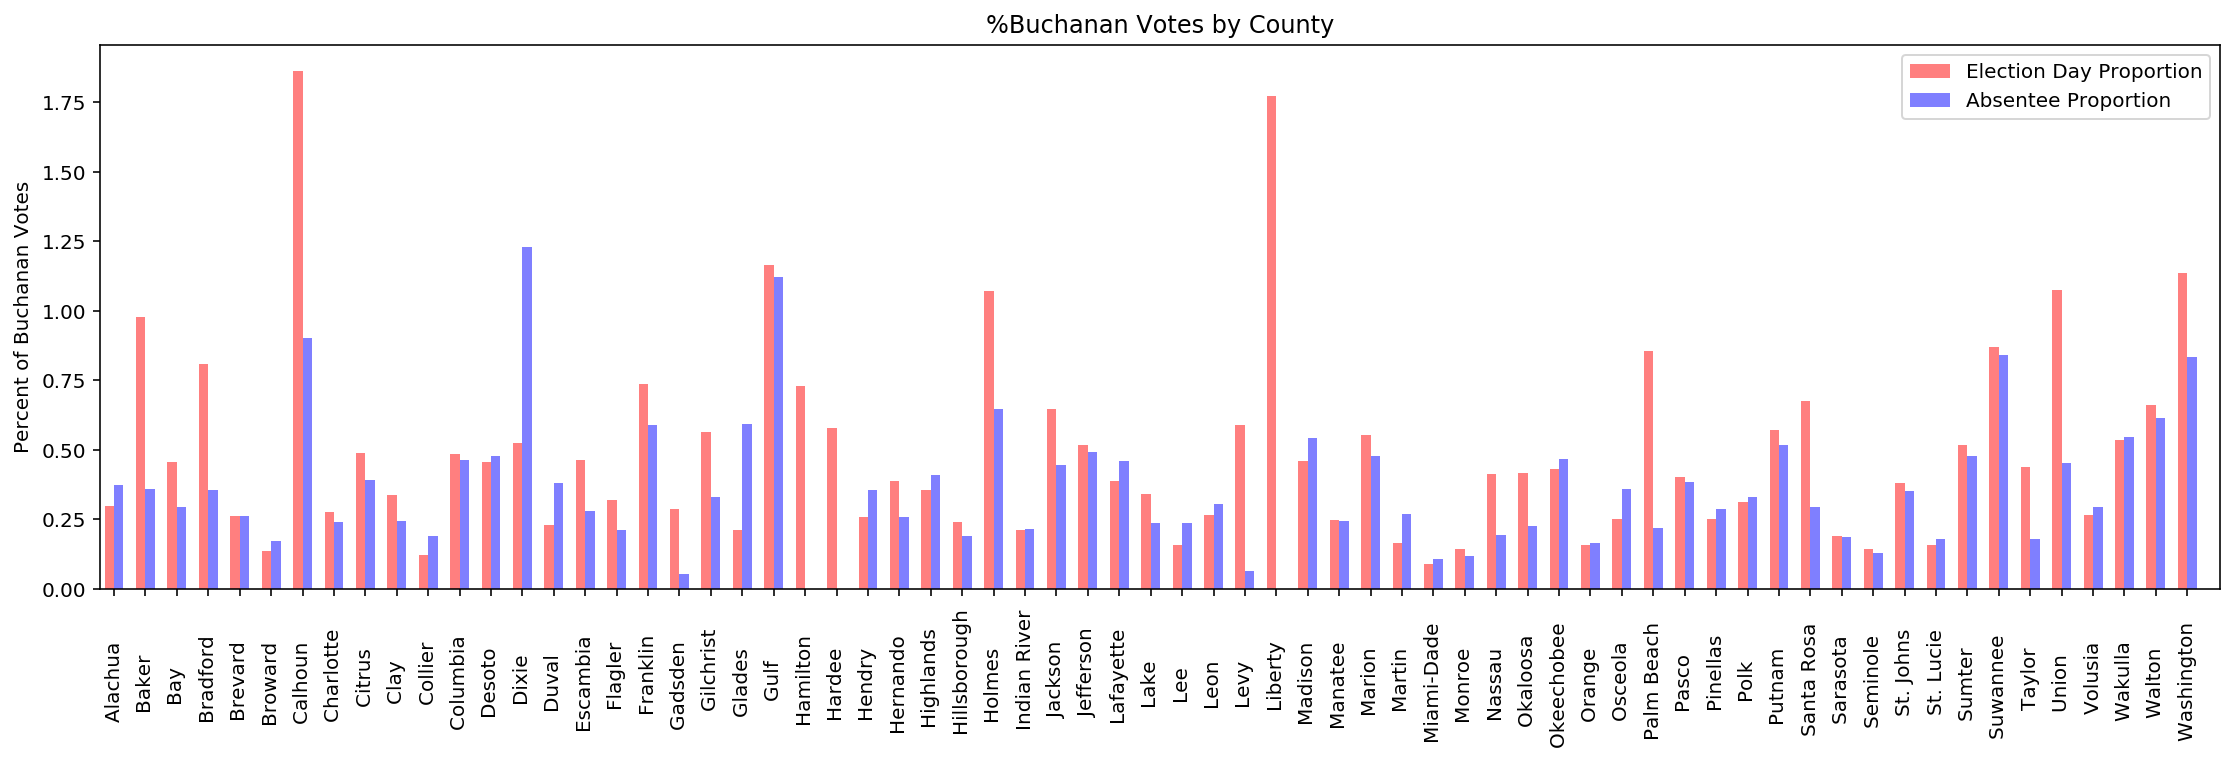

In [59]:
# Setting the positions and width for the bars
pos = list(range(len(fl_counties['county']))) 
width = 0.3

#Proportionsal vote counts
elecbuch_prop = ((fl_counties.buchananVotes - fl_counties.absBuchanan)/(fl_counties.totalVotes - fl_counties.absVotes))*100
absenbuch_prop = (fl_counties.absBuchanan/ fl_counties.absVotes)*100

# Plotting the bars
fig, ax = plt.subplots(figsize=(19,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, elecbuch_prop, 
        width, alpha=0.5, color='r', label=fl_counties.county) 

plt.bar([p + width for p in pos], absenbuch_prop,
        width, alpha=0.5, color='b', label=fl_counties.county) 

# Set the y axis label
ax.set_ylabel('Percent of Buchanan Votes')

# Set the chart's title
ax.set_title('%Buchanan Votes by County')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])
plt.xticks(rotation = 'vertical')

# Set the labels for the x ticks
ax.set_xticklabels(fl_counties.county)

# Setting the x-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.legend(['Election Day Proportion', 'Absentee Proportion'])
plt.show()

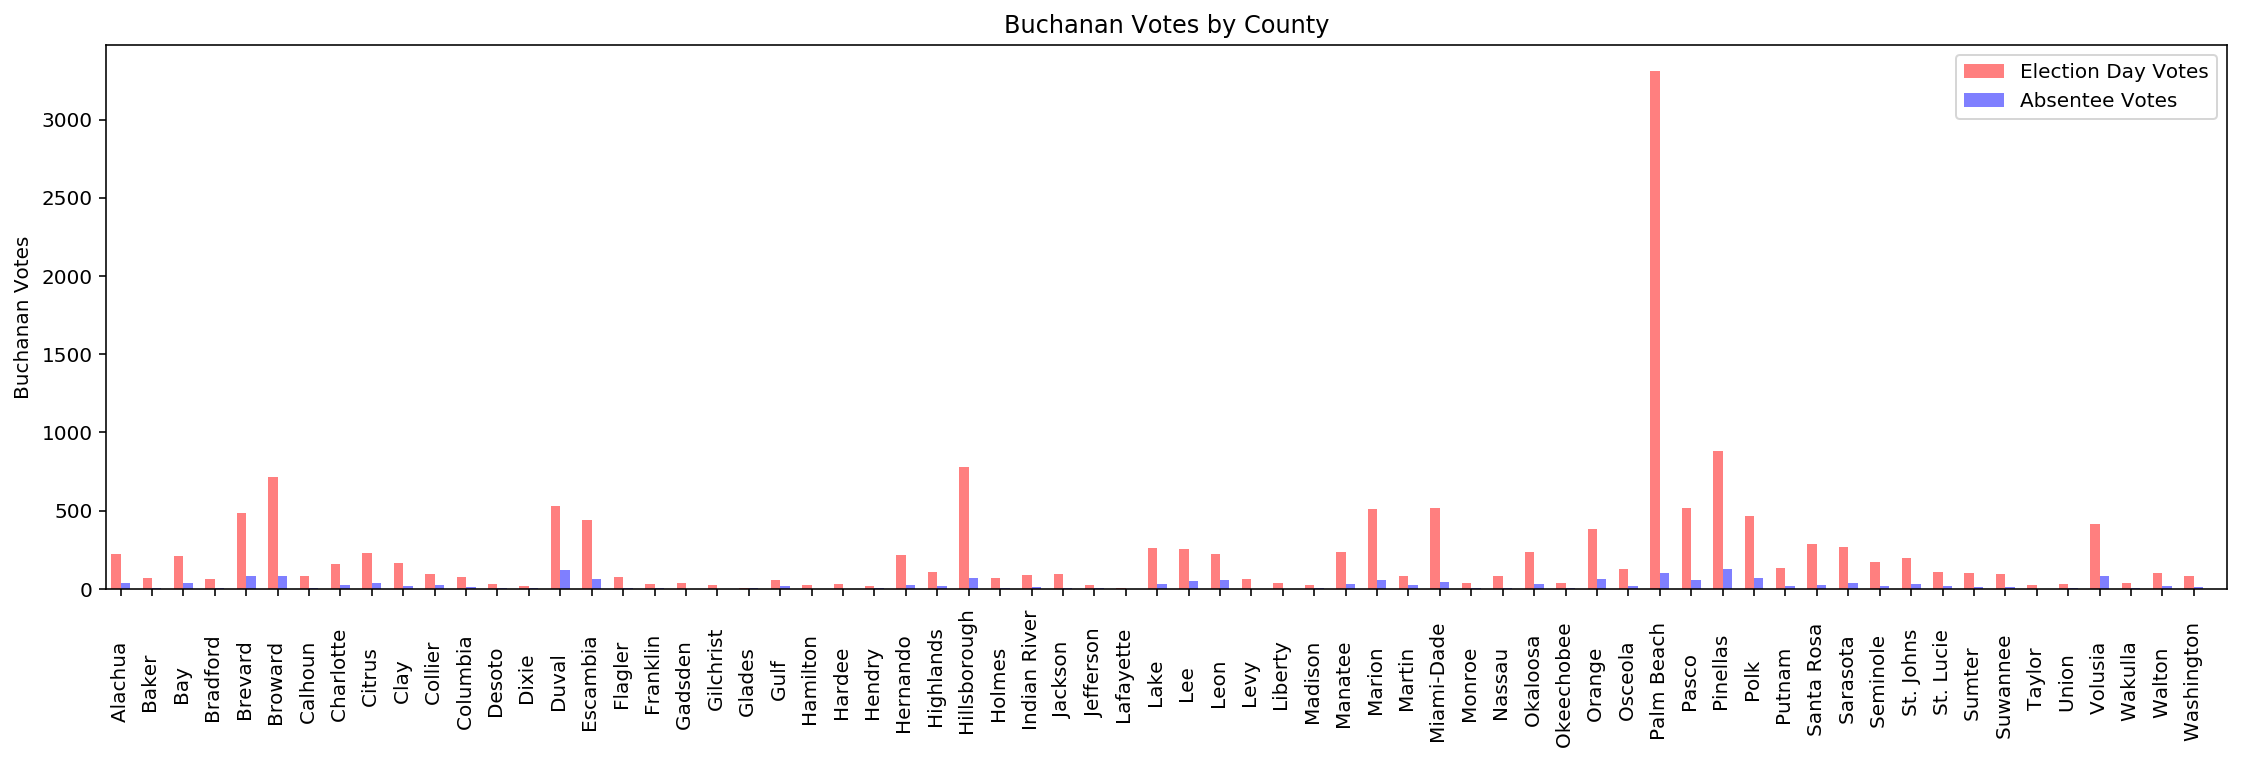

In [60]:
# Setting the positions and width for the bars
pos = list(range(len(fl_counties['county']))) 
width = 0.3

#Raw vote coutnts
elecbuch= (fl_counties.buchananVotes - fl_counties.absBuchanan)
absenbuch = fl_counties.absBuchanan

# Plotting the bars
fig, ax = plt.subplots(figsize=(19,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, elecbuch, 
        width, alpha=0.5, color='r', label=fl_counties.county) 

plt.bar([p + width for p in pos], absenbuch,
        width, alpha=0.5, color='b', label=fl_counties.county) 

# Set the y axis label
ax.set_ylabel('Buchanan Votes')

# Set the chart's title
ax.set_title('Buchanan Votes by County')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])
plt.xticks(rotation = 'vertical')

# Set the labels for the x ticks
ax.set_xticklabels(fl_counties.county)

# Setting the x-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.legend(['Election Day Votes', 'Absentee Votes'])
plt.show()

Looking at the first barchat it appears that on average absentee Buchanan proportions (blue) tend to be on par with or slightly lower than election day Buchanan proportions. If we use absentee proportions to project election day proportion our esimate will probably be a bit conservative. 

In the first graph, we see that Liberty and Calhoun counties have the largest proportion (approx. 1.7%) of Buchanan voters but this is a bit deceptive since both these counties have less than 6000 total votes cast. That means around 100 people voted for Buchanan in these counties. But from the second barchart you can see more than 3500 people votes for Buchanan in PBC. Intiutively, it's a lot easier to mobilize 100 people to vote for you than it is to mobilize 3500 people. This distortion is again due to the size discrepencies between the county sizes. In statistics, LLN states that in smaller samples we tend to see greater variability of averages, but as sample size increases, variance decreases and we expect the average to settle at some "true" proportion. We have to make sure our model can account for natural distortion.

# Overdispersed Binomial Model

Let's say we can model Buchanan votes in a county using the binomial distribution with $p_i$ as the 'true' probabilty a voter would vote for Buchanan in $county_i$ and $n$ as the number of voters in $county_i$. Then we can compare PBC's observed Buchanan vote share $n\hat{p}_{PBC}$ with the expected vote share $np_{PBC}$ to determine whether PBC Buchanan support represents an anomaly.

The binomial however assumes that voters are independent and identicially distributed whithin each county which social scientists know is not true. Voters in the same demographic groups (race, sex, region, etc.) tend to vote similarly. This covariance amongst voters results in a larger variance than the usual $np_i(1-p_i)$ of the binomial model.

In the readings, Wand et al. state that the standard deviation of voter behavior tends to be 3.8 times larger than the usual binomial standard deviation. So a more accurate model for our data will be the overdispersed binomial where our standard deviation is enlarged by a factor of 3.8.

Using our model we can plot the standardized differences between ebsentee Buchanan vote share and election day vote share (essentially what we did in plot 1 but standardized using our new model assumptions).

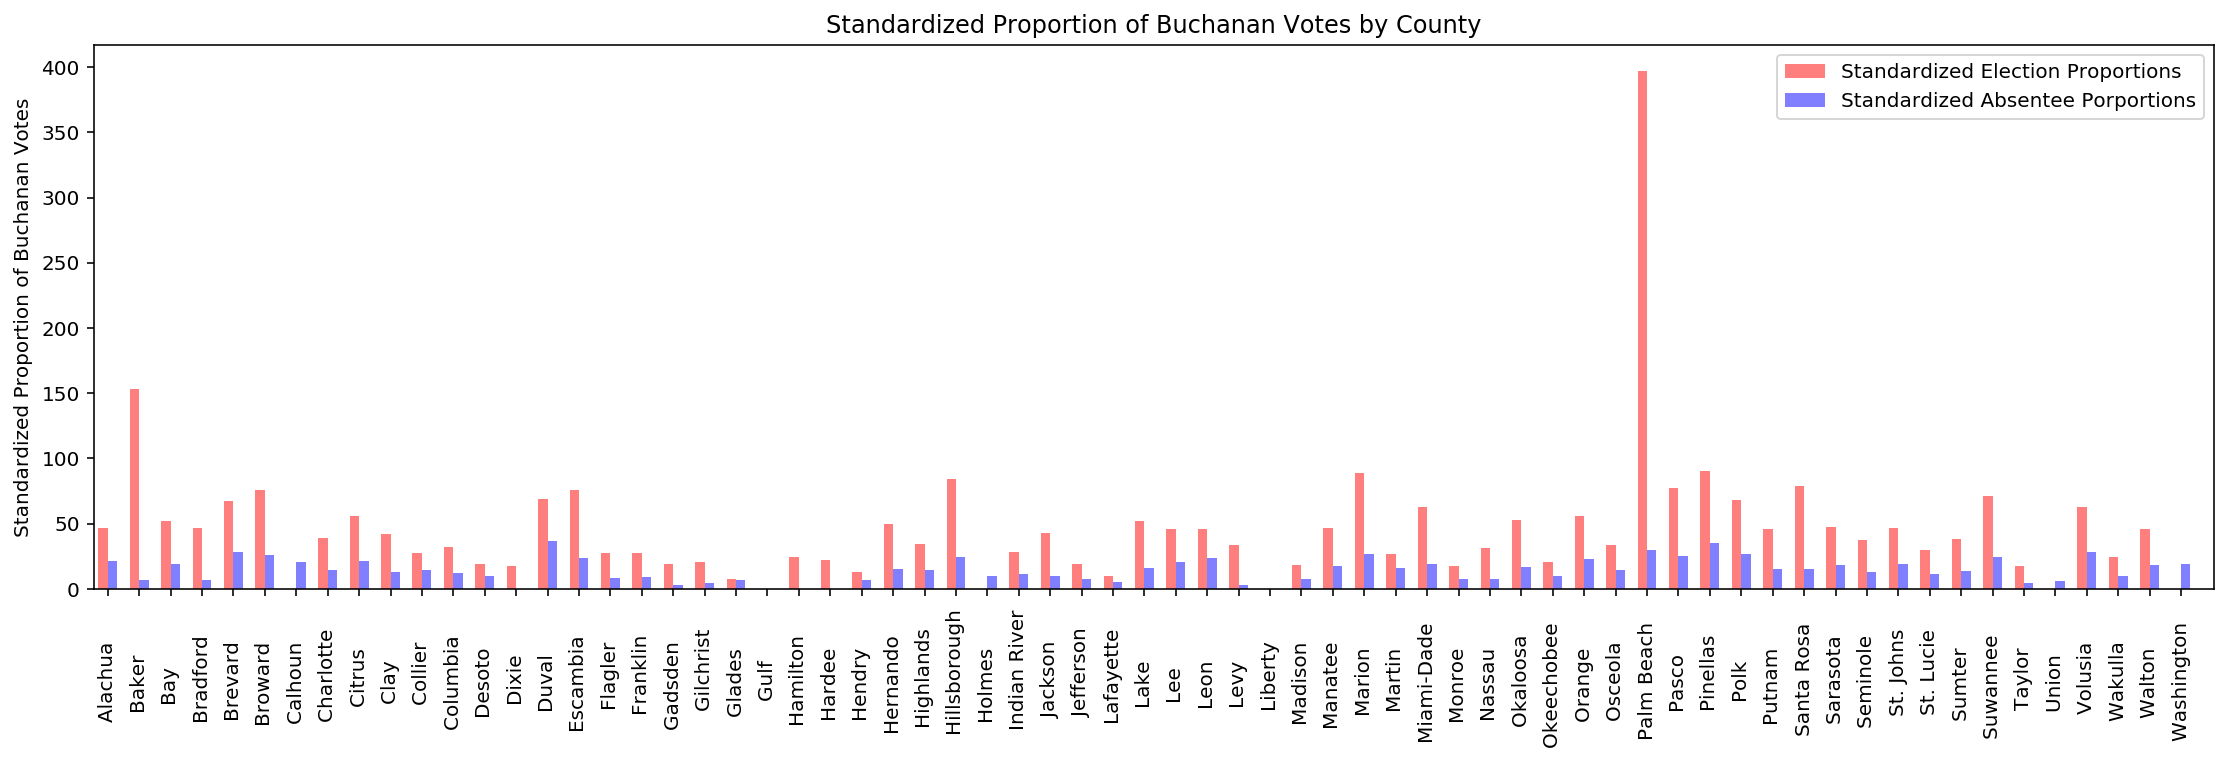

In [61]:
# Setting the positions and width for the bars
pos = list(range(len(fl_counties['county']))) 
width = 0.3

#Calculating estimated sample standard deviations for both election day and absentee pools
elecbuch_sd = 3.8 * np.sqrt(((elecbuch_prop)*(1-elecbuch_prop))/(fl_counties.totalVotes - fl_counties.absVotes))
absbuch_sd = 3.8 * np.sqrt(((absenbuch_prop)*(1-absenbuch_prop))/fl_counties.absVotes)

#Standardizing election day and absentee proportions with the calculated estimated sds'
stelecbuch_prop = elecbuch_prop/elecbuch_sd
stabsenbuch_prop = absenbuch_prop /absbuch_sd

# Plotting the bars
fig, ax = plt.subplots(figsize=(19,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, stelecbuch_prop, 
        width, alpha=0.5, color='r', label=fl_counties.county) 

plt.bar([p + width for p in pos], stabsenbuch_prop,
        width, alpha=0.5, color='b', label=fl_counties.county) 

# Set the y axis label
ax.set_ylabel('Standardized Proportion of Buchanan Votes')

# Set the chart's title
ax.set_title('Standardized Proportion of Buchanan Votes by County')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])
plt.xticks(rotation = 'vertical')

# Set the labels for the x ticks
ax.set_xticklabels(fl_counties.county)

# Setting the x-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.legend(['Standardized Election Proportions', 'Standardized Absentee Porportions'])
plt.show()

Note that by standardizing both absentee and election day voters by their sample standard deviations, we are correcting for the distortion we saw before. In the above plot, PBC election day proportions are significantly higher than all other counties, and significantly higher than its own absentee proportion. 


# Natural Experiments

If we make the assumption that absentee voters and eleciton day voter from each county are samples from the same population (ie. have the same $p_i$) then we have an natural experiment on our hands since one group (election day voters) recieved the butterfly ballot and one group (absentee voters) did not. If we make the additional assumption that the two samples are more or less random we can take a look at the standardized differenes in election day and absentee voters. See below:

$E[p_{elec} - p_{abs}] = E[p_{elec}]+ E[p_{abs}]$

If we assume random samples, we can caculate the standard deviation of the differences

$SD[p_{elec} - p_{ebs}] = \sqrt{Var(p_{elec}) + Var(p_{abs})}$

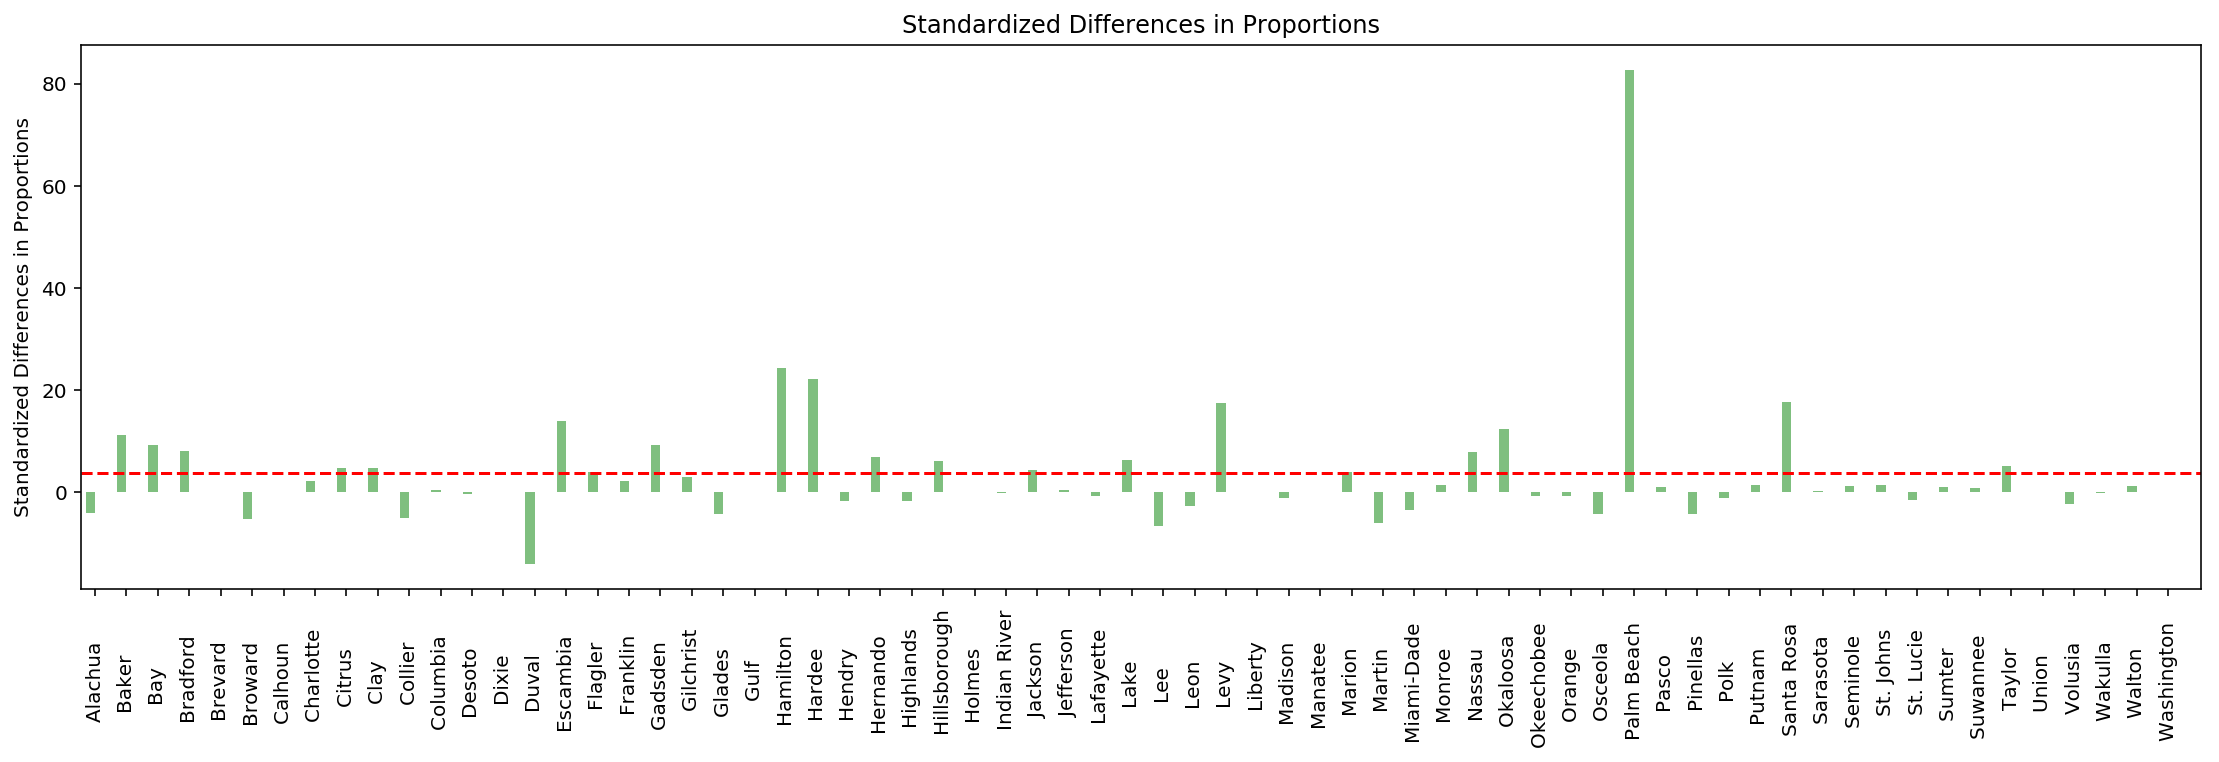

In [76]:
# Setting the positions and width for the bars
pos = list(range(len(fl_counties['county']))) 
width = 0.3

#Calculating estimate of standard deviation of difference
diff_sd = np.sqrt(elecbuch_sd**2 + absbuch_sd**2)

#Standardizing election day and absentee proportions with the estimated sd
stdiff = (elecbuch_prop - absenbuch_prop)/diff_sd

# Plotting the bars
fig, ax = plt.subplots(figsize=(19,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, stdiff, 
        width, alpha=0.5, color='g', label=fl_counties.county)

#Plotting average line
plt.axhline(np.nanmean(stdiff), color='r', linestyle='--')

# Set the y axis label
ax.set_ylabel('Standardized Differences in Proportions')

# Set the chart's title
ax.set_title('Standardized Differences in Proportions')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])
plt.xticks(rotation = 'vertical')

# Set the labels for the x ticks
ax.set_xticklabels(fl_counties.county)

# Setting the x-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.show()

The dashed red line above represents the average of all the differences. It's clear the between PBC has a much larger standardized difference between proportion of election day Buchanan voters and proportion of absentee Buchanan voter. The seems like the butterfly ballot used PBC did cause election day voters to accidently vote for Buchanan. 

But let's rexamine our assumptions. We asssumed that absentee voters from a county would be a representative of election day voters from the same county. This may not be a valid assumption, when you consider absentee voters all live outside PBC. Perhaps geographic proximity is a closer indicator of how people may vote. 

Let's take a closer look at the difference between PBC election day proportions and neighboring county's election day proportions. 

![](fig/flcountymap.jpg)

So Broward, Hendry, Glades and Martin counties surround PBC. Let's pool together the votes from these counties, find the $p_{neighbors}$ and $SD(p_{neighbors})$. We make the assumption as we did before that PBC election day voters and neighboring county eleciton day voters are 2 randomly samples from the same population. Then we would expect the difference of their proportions to equal zero. 

We can calcuate the z score of the differences

In [169]:
df = pd.DataFrame({'County': county, 'ElecBuchvotes':elecbuch, 'ElectTotalvotes': (fl_counties.totalVotes - fl_counties.absVotes).tolist()})
neighbors = ['Broward', 'Hendry', 'Glades', 'Martin']
Buch_neigh = 0
total_neigh = 0

for i in neighbors:
    Buch_neigh = Buch_neigh + int(df[df.County == i].ElecBuchvotes)
    total_neigh = total_neigh + int(df[df.County == i].ElectTotalvotes)
    
# Calculating estimated p_neighbors and p_PBC
p_neigh = Buch_neigh/total_neigh
p_PBC = df[df.County == "Palm Beach"].ElecBuchvotes / df[df.County == "Palm Beach"].ElectTotalvotes

# Calculating estimated SD_neighbors and SD_PBC
sd_neigh = 3.8 * np.sqrt(((p_neigh)*(1-p_neigh))/total_neigh)
sd_PBC = 3.8 * np.sqrt(((p_PBC)*(1-p_PBC))/df[df.County == "Palm Beach"].ElectTotalvotes)

# Computing difference between neighbors and PBC
diff = p_PBC - p_neigh

#Calculating estimate of standard deviation of differences
diff_sd = np.sqrt(sd_neigh**2 + sd_PBC**2)

#Computing z score of differences
stdiff = (diff - 0)/diff_sd
float(stdiff)

12.085738753314663

Difference between PBC and it's nighboring counties is nrealy 12 SD's above the expected difference of 0. All our analysis thus far point to the same conclusion. The PBC election day Buchanan vote share in the 200 Presidential election is much higher than it was expected to be. 

# Impact of the Miscast

Having identified the anomaly, let's try to estimate how many votes may have been miscasted. If we use PBC's absentee  proportions, then we would have expected to see...

In [179]:
absprop_PBC = absenbuch_prop[49]/100
int(df[df.County == "Palm Beach"].ElectTotalvotes * absprop_PBC)

853

...853 votes. But we saw 3310, meaning 3310-853= 2,457 votes were miscasted. If we use PBC's neighbors proporitons, then we would expected to see...

In [180]:
p_neigh * int(df[df.County == "Palm Beach"].ElectTotalvotes)

540.37122952491

540 votes, making 3310-540 = 2,770 votes miscasted. Both these models support the conclusion that the effect of the butterfly ballot was large enough to have given Al Gore all of Florida's electoral votes and subsequently the Presidency. 